# Directed hierarchical random graph
In this example, we will see how the algorithm works in a directed hierarchical random graph created by using the model from [Sales-Pardo M. et al. 2007](https://doi.org/10.1073/pnas.070374010)

First, let's import the libraries that we are going to use.

In [1]:
T = True
F = False
# Stadard python libs ----
import numpy as np
import seaborn as sns
sns.set_theme()
# Personal libs ----
from networks.toy import TOY
from modules.main import ELK
from modules.colregion import colregion
from plotting_jupyter.plotting_H import Plot_H
from various.network_tools import get_labels_from_Z, get_best_kr_equivalence

Create the HGR class that will create a homogeneous-directed hierarchical random graph with three levels. Depending on the level, two nodes belonging to the same community connect with probability $p=\frac{2}{360}$ for $l=0$, $p=\frac{2}{159}$ for $l=1$, $p=\frac{4}{39}$ for $l=2$, and $p=\frac{8}{9}$ for $l=3$.

In [2]:
class HRG:
  def __init__(self, N : int, group_sizes=[160, 40, 10], rho=1, kav=16, seed=-1) -> None:
    self.nodes = N
    self.rho = rho
    self.kav = kav
    self.group_sizes = np.array(group_sizes)
    self.lmax = len(group_sizes)
    self.A = np.zeros((N, N))
    self.labels = np.arange(N, dtype=int).astype(str)
    self.generate_membership_list()
    self.fill_adjacency_matrix(seed=seed)

  def get_p(self):
    p = np.zeros(len(self.group_sizes) + 1)
    p[0] = np.power(self.rho, self.lmax) / np.power(1 + self.rho, self.lmax) * (self.kav / (self.group_sizes[0] * self.lmax))
    for x, Sx in enumerate(self.group_sizes):
      x += 1
      p[x] = np.power(self.rho, self.lmax - x) / np.power(1 + self.rho, self.lmax - x + 1) * (self.kav / (Sx - 1))
    return p

  def fill_adjacency_matrix(self, seed=-1):
    if seed > 0:
      np.random.seed(seed)
    p = self.get_p()
    for i in np.arange(self.nodes):
      for j in np.arange(self.nodes):
        if i == j: continue
        members_i = self.node_memberships[i, :]
        members_j = self.node_memberships[j, :]
        compare = members_i == members_j
        kk = 0
        for k in np.arange(self.node_memberships.shape[1]):
          if compare[k]: kk += 1
          else: break
        if np.random.rand() < p[kk]: self.A[i, j] = 1      

  def generate_membership_list(self):
    memberships_options = np.arange(self.lmax + 1)
    self.node_memberships = np.zeros((self.nodes, len(self.group_sizes)))
    for i, size in enumerate(self.group_sizes):
      mem = np.repeat(memberships_options, size)
      if len(mem) < self.nodes:
        mem = np.tile(mem, int(self.nodes / len(mem)))
      self.node_memberships[:, i] = mem

Let's start defining some parameters for the algorithm and assigning them to a dictionary.

In [3]:
linkage = "single"
lookup = F
cut = T                                       # We are reducing the number of steps in the
                                              # quality function maximization step by only
                                              # considering the steps where the distance
                                              # between merged link communities changed between
                                              # consecutive steps
mode = "ZERO"
topology = "MIX"
index = "H2"

properties = {
  "structure" : "HRG",
  "lookup" : lookup,
  "cut" : cut,
  "topology" : topology,
  "index" : index
}

We are going to create a network with 64O (N) nodes and let's run the code!

In [4]:
# Define parameters HRG
N = 640
hrg = HRG(N, seed=12345)
perm = np.random.permutation(np.arange(N))
hrg.A = hrg.A[perm, :][:, perm]                           # Permutation of the network before analysis
labels_dict = {i: hrg.labels[i] for i in np.arange(N)}
# Create TOY ---
NET = TOY(hrg.A, **properties)
NET.set_labels(hrg.labels)
H = ELK(hrg.A, N, linkage, mode, **properties)
## Compute quality functions ----
H.compute_H_features_cpp()
## Compute link entropy ----
H.link_entropy_cpp("short", cut=cut)
## Compute la arbre de merde ----
H.la_abre_a_merde_cpp()
## Compute node entropy ----
H.node_entropy_cpp("short", cut=cut)
# Set labels to network ----
L = colregion(NET)
L.get_regions()
H.set_colregion(L)
H.set_entropy([
  H.node_entropy, H.node_entropy_H,
  H.link_entropy, H.link_entropy_H
])

Compute link hierarchical agglomeration ----
	> Compute features
Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 18685

	link entropy :  Sh : 0.3216, and Sv : 0.6784


	link entropy H: Sh : 0.3363, and Sv : 0.6637

	> Compute the node hierarchy ----
Commencer: la abre a merde
Voila, bon ami
Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 1279

	Node entropy :  Sh : 0.5565, and Sv : 0.4435


	Node entropy H: Sh : 0.5396, and Sv : 0.4604



Let's see how the quality functions look like before looking at the node community partitions.

	> Visualize Hierarchical Entropy by levels!!!
Levels node hierarchy: 20
Levels link hierarchy: 1641
             S dir                 c  level
49    0.075092   H  node_hierarchy_H     11
72    0.055241   V  node_hierarchy_H      8
7     0.077235   H    node_hierarchy     13
26    0.043164   V    node_hierarchy     14
3394  0.007106   H  link_hierarchy_H   1609
5035  0.008759   V  link_hierarchy_H   1609
106   0.006310   H    link_hierarchy   1615
1746  0.006534   V    link_hierarchy   1616
	> Plot loop entropy as a function of K
Plot X as a function of K
	> Plot D as a function of K


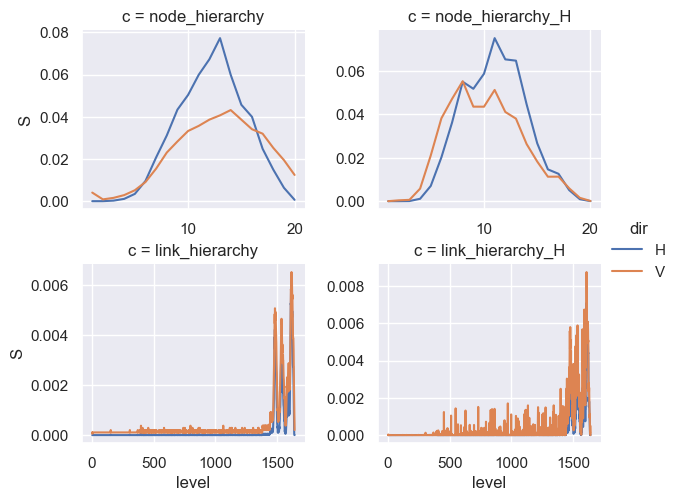

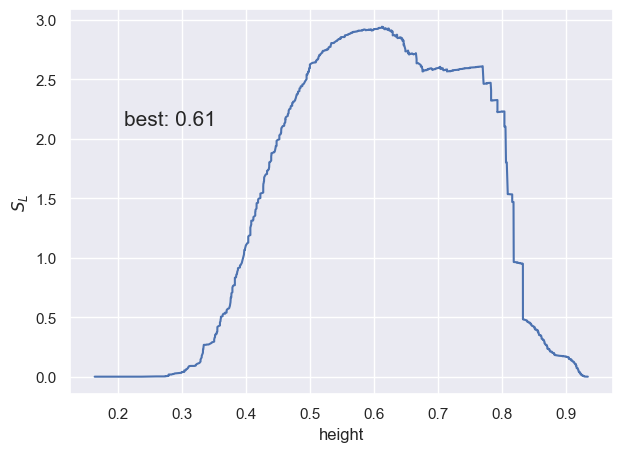

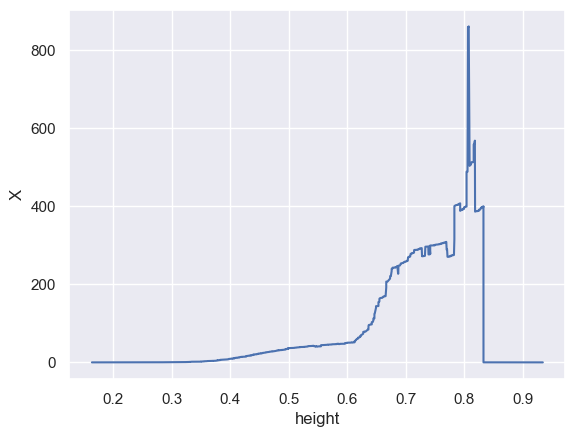

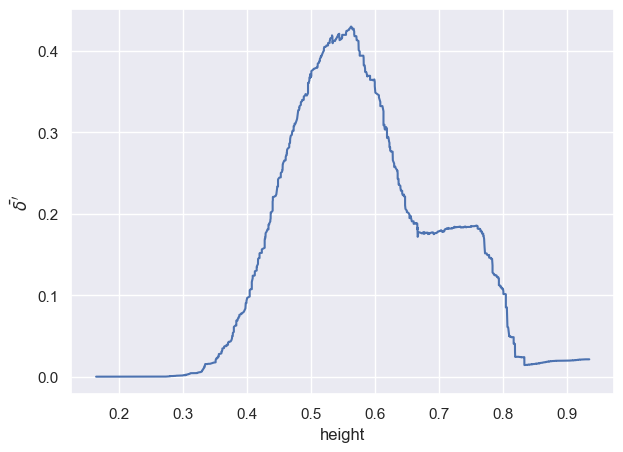

In [5]:
plot_h = Plot_H(H)
plot_h.plot_Hierarchical_Entropy(width=7, height=5)
plot_h.plotSL(width=7, height=5)
plot_h.plotX(width=7, height=5)
plot_h.plotD(width=7, height=5)

Notice the big jump in the order parameter. In the case of the existence of balanced similarity forces spanning the network, link communities will tend to form sparsely across the network. They will start agglomerating links and create robust structures. After a certain point, these structures collapse because of the vacuum force, making the giant component grow without control and overtaking the network. There are many parallels in the link between hierarchical agglomeration and percolation. In addition, by looking at the $H_{L}$-, $\chi$-score plots, we can observe how they tend to peak closer to the emerging of the giant component than $D$.

Now, look at the partition of the loop entropy $H_{L}$:

In [6]:
score = "_SL"
k, r = get_best_kr_equivalence(score, H)
plot_h.lcmap_dendro(
  r, k, cmap_name="husl", remove_labels=True
)
plot_h.nodal_dendrogram(
  r, cmap_name="husl", remove_labels=True
)

The $\chi$ quality function

In [ ]:
score = "_X"
k, r = get_best_kr_equivalence(score, H)
plot_h.lcmap_dendro(r, k, cmap_name="husl", remove_labels=True)
plot_h.nodal_dendrogram(r, cmap_name="husl", remove_labels=True)

And the average link community density, $D$.

In [ ]:
score = "_D"
k, r = get_best_kr_equivalence(score, H)
rlabels = get_labels_from_Z(H.Z, r)
plot_h.lcmap_dendro(r, k, cmap_name="husl", remove_labels=True)
plot_h.nodal_dendrogram(r, cmap_name="husl", remove_labels=True)

## Conclusions

In this example, we can see that ELK works well in the case of hierarchical networks. The performance of the quality functions teaches us several things.

- The $\chi$ score returns a partition with a colder K (fewer number of link communities).

- The Loop entropy, $S_{L}$, and average link community density, $\bar{\delta'}$, found the warmest partition from the first hierarchy level with 64 node communities. We understand that this partition comes naturally since the network is sparse, making the subclusters' density the feature to organize the data. Surprisingly, this partition has the highest loop entropy, i.e., where the distribution of the number of effective links is the most homogeneous.

Besides the performance of the quality functions, the real structure that encodes most of the organization's information in this network is the node community dendrogram.